## Libraries

In [42]:
# standard libraries
import string
import re
import numpy as np
import pandas as pd

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn for test train splits
from sklearn.model_selection import train_test_split

# Ridge regression regularization (L2)
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_union

# Data wrangling
import re
from nltk.corpus import stopwords
eng_stp_words = stopwords.words('english')


## Loading kaggle data_sets into Pandas dataframes

In [43]:
# tsv is tab separeted so... delimiter='\t'
data_set = pd.read_csv('Data/train.tsv', delimiter='\t', encoding='utf-8')

# test_set not required yet 
# test_set = pd.read_csv('Data/test.tsv', delimiter='\t', encoding='utf-8')
# test_stg2 = pd.read_csv('Data/test_stg2.tsv', delimiter='\t', encoding='utf-8')

# check pandas dataframe dimension
print('Data frames loaded:')
print('data_set shape:', data_set.shape)
# print('test_set shape:', test_set.shape)
# print('test_stg2 shape:', test_stg2.shape)

Data frames loaded:
data_set shape: (1482535, 8)


## Data fields for reference:
(from kaggle competition)

The files consist of a list of product listings. These files are tab-delimited.
* train_id or test_id - the id of the listing
* <b>name</b> - the title of the listing. Note that we have cleaned the data to remove text that look like prices to avoid leakage. These removed prices are represented as [rm]
* <b>item_condition_id</b> - the condition of the items provided by the seller, 1=Good,...,5=Poor
* <b>category_name</b> - category of the listing
* <b>brand_name</b>
* <b>price</b> - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
* <b>shipping</b> - 1 if shipping fee is paid by seller and 0 by buyer
* <b>item_description</b> - the full description of the item. Note that we have cleaned the data to remove text that look like prices to avoid leakage. These removed prices are represented as [rm]

## Data exploration - visualization

Summary so far:
 * There are unique <b>4,810</b> brands.
 * There are <b>82,489</b> items with <b>"No description yet"</b>, around 6% of our dataset. (what you think)
 * There are <b>874</b> entries with <b>price = 0/free</b>, should we drop them? as it does not make sence and will confuse our model I think.
 * prices are skewed to the right.
 * top brands (PINK, Nike, Victoria's Secret, etc)
     * Note there are <b>632,682</b> items with no brand assigned ~ 43% of our training set!

In [44]:
# check data 
data_set.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [45]:
# group by brands and check the most popular
brands = data_set.groupby(['brand_name']).size()

print('There are unique brands:', brands.shape[0])
print('of which {} have no brand assigned'.format(data_set[data_set['brand_name'].isnull()].shape[0]))

brands.sort_values(ascending=False).head(20)

There are unique brands: 4809
of which 632682 have no brand assigned


brand_name
PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
FOREVER 21           15186
Nintendo             15007
Lululemon            14558
Michael Kors         13928
American Eagle       13254
Rae Dunn             12305
Sephora              12172
Coach                10463
Disney               10360
Bath & Body Works    10354
Adidas               10202
Funko                 9237
Under Armour          8461
Sony                  7994
Old Navy              7567
dtype: int64

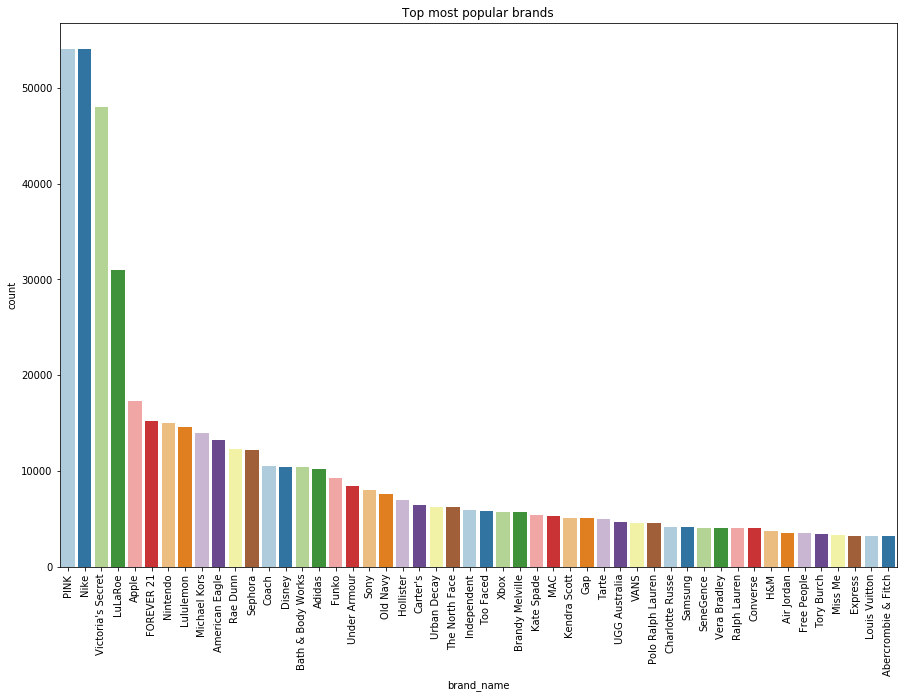

In [46]:
# Top 20 common Brands
top_brands = data_set['brand_name'].value_counts()[0:50].reset_index()\
            .rename(columns={'index': 'brand_name', 'brand_name':'count'})

plt.figure(figsize=(15,10))
ax = sns.barplot(x="brand_name", y="count", data=top_brands, palette='Paired')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

# set title
ax.set_title('Top most popular brands')
plt.show()

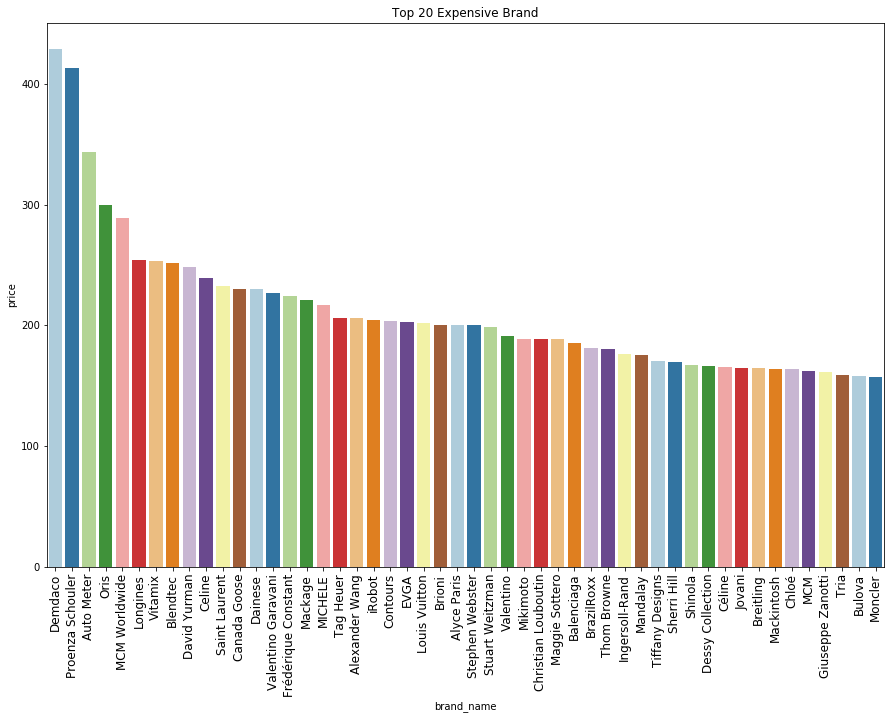

In [47]:
# Display Top 20 Expensive Brands By Mean Price
top_expensive = data_set.groupby('brand_name', axis=0).mean()
df_top_expensive = pd.DataFrame(top_expensive.sort_values('price', ascending = False)\
                                ['price'][0:50].reset_index())


plt.figure(figsize=(15, 10))
ax = sns.barplot(x="brand_name", y="price", data=df_top_expensive, palette='Paired')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)

# set title
ax.set_title('Top 20 Expensive Brand')
plt.show()

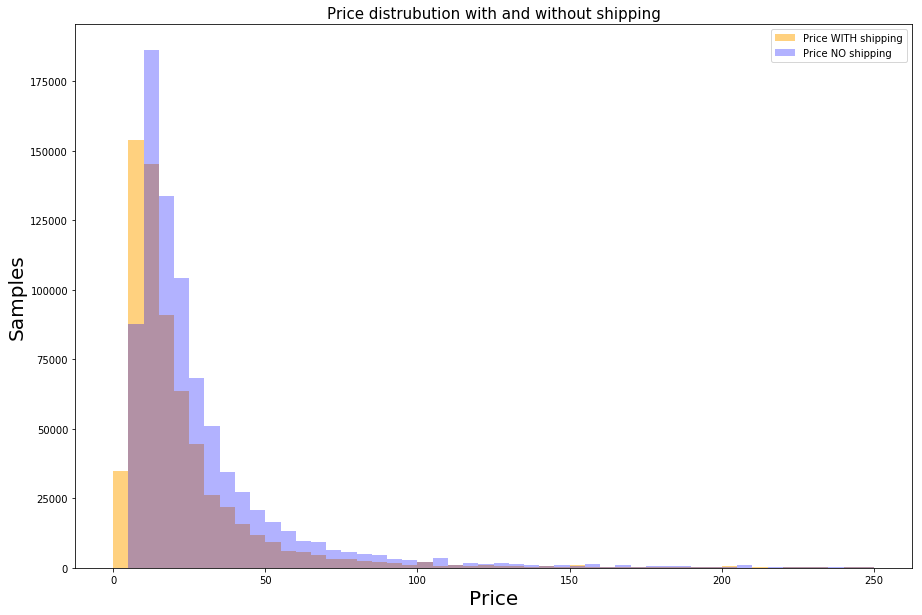

In [185]:
shipping = data_set[data_set['shipping']==1]['price']
no_shipping = data_set[data_set['shipping']==0]['price']

plt.figure(figsize=(15, 10))
plt.hist(shipping, bins=50, range=[0,250], alpha=0.5, label='Price WITH shipping', color='orange')
plt.hist(no_shipping, bins=50, range=[0,250], alpha=0.3, label='Price NO shipping', color='blue')
plt.title('Price distrubution with and without shipping', fontsize=15)

plt.xlabel('Price', fontsize=20)
plt.ylabel('Samples', fontsize=20)
plt.legend()

plt.show()

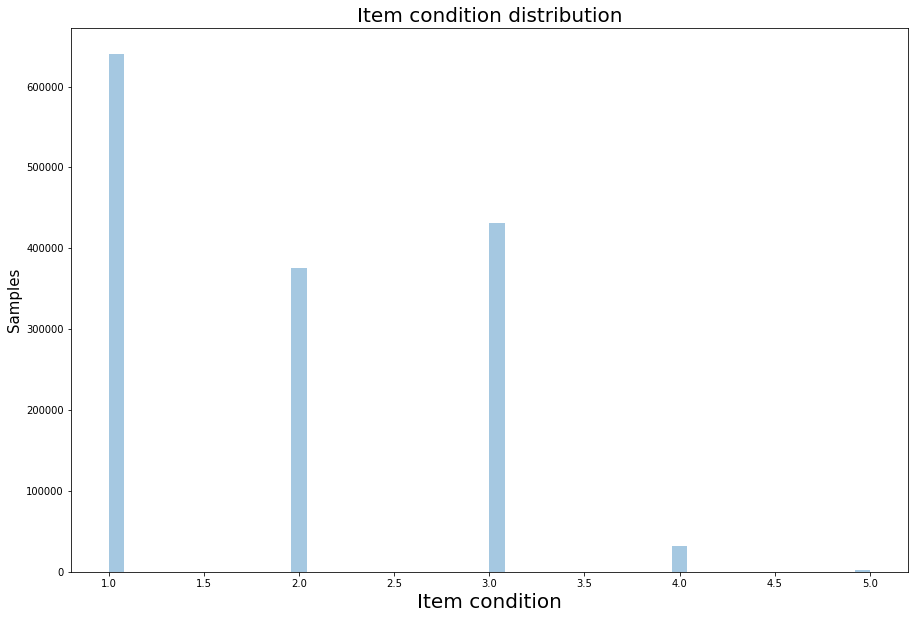

In [178]:
plt.figure(figsize=(15, 10))

ax = sns.distplot(data_set['item_condition_id'], kde=False)

plt.title('Item condition distribution', fontsize=20)
plt.xlabel('Item condition', fontsize=20)
plt.ylabel('Samples', fontsize=15)

plt.show()

In [186]:
# items with no description
no_description = data_set[data_set['item_description']=='No description yet']
print('There are {} items with no description'.format(no_description.shape[0]))
# select top 5
no_description.head(5)

There are 82427 items with no description


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
13,13,Sharpener and eraser,1,Other/Office supplies/School Supplies,Scholastic,4.0,1,No description yet
31,31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",NaN,50.0,1,No description yet
90,90,Jewel holder,2,Home/Storage & Organization/Jewelry Boxes & Or...,Target,7.0,1,No description yet
117,117,Eyeko liquid eyeliner,1,Beauty/Makeup/Eyes,NaN,5.0,1,No description yet


<Figure size 1080x720 with 0 Axes>

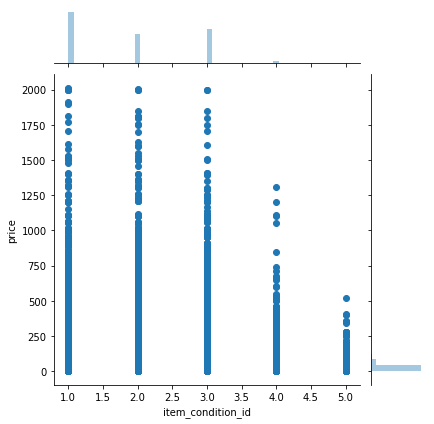

In [199]:
# looking for correlations between price and item condition
# expect to get higher price from items in condition = 1, cheaper as condition = 5
# there is not a very clear correlation other than bad items tend to be cheaper

plt.figure(figsize=(15, 10))
sns.jointplot(x="item_condition_id", y="price", data=data_set)

plt.show()

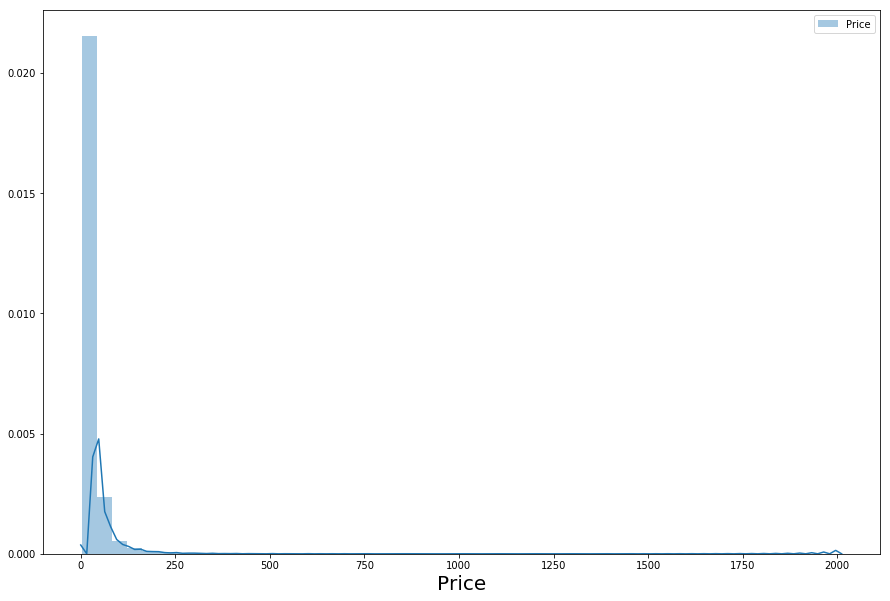

In [55]:
# see prices, everything seems to be on the "cheaper side"
plt.figure(figsize=(15, 10))
ax = sns.distplot(data_set['price'], label='Price')
plt.xlabel('Price', fontsize=20)

plt.legend()
plt.show()

# Data wrangling and Cleansing

* There are <b>874</b> entries with <b>price = 0/free</b>, should we drop them? as it does not make sence and will confuse our model I think.
* Replace <b>NaN</b> values with empty spaces?

In [53]:
# free items??? price == 0
# not very useful

data_set[data_set['price']==0].head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3576,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
3761,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...


In [54]:
# data cleansing

# replace NaN values with empty cells
# data_set = data_set.fillna('')
# keep only items that have a price
data_set = data_set[data_set['price']!=0]

data_set.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


### Transforming strings
contains some functions to transform sentences

* remove english stopwords:
    * <b>remove_stop_words(sentence)</b>
        * should dicuss if we need to remove words like 'no', 'not'
        * full list of nltk words cell below.
* make sentence to lowercase:
    * <b>to_lower_case(sentence)</b>
* remove_numbers from sentence:
    * <b>remove_numbers(sentence)</b> 
* remove special characters from sentence expcept white spaces:
    * <b>remove_special_chars(sentence)</b>
    
Apply these transformation to colums 'item_description' and 'name'

In [48]:
# should we keep some words from this list?
# ('no', 'nor', 'not', 'few') do they indicate something useful like negative description?
print('full list of stop words:\n', eng_stp_words)
# 179 words
print('# words:', len(eng_stp_words))

# use this string to ged rid of nltk library
#['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves','you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


full list of stop words:
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own

In [47]:
# cdata transformation functions

def remove_stop_words(sentence):
    """ using the nltk lib, gets rid of english stopwords """
    
    sentence = ' '.join([w for w in sentence.split(' ') if w not in eng_stp_words])
    
    return sentence

def to_lower_case(sentence):
    """ returns lower case """
    
    lower_sentence = sentence.lower()
    
    return lower_sentence

def remove_numbers(sentence):
    """ removes numeric values from sentence using regular expression """
    
    sentence_no_digit = re.sub(r'\d+', '', sentence)
    
    return sentence_no_digit

def remove_special_chars(sentence):
    """ removes special characters from sentence using regular expression """
    
    # remove special characters EXCEPT white spaces
    sentence_no_spchar = re.sub(r'\W+',' ', sentence)
    
    return sentence_no_spchar

def clean_sentence(sentence):
    """ piles up cleaning functions defined by the team """
    
    # lowercase
    sentence = to_lower_case(sentence)
    # remove stopwords
    sentence = remove_stop_words(sentence)
    # remove numbers
    sentence = remove_numbers(sentence)
    # remove special characters
    sentence = remove_special_chars(sentence)
    
    return sentence

In [49]:
# test # 
print(clean_sentence('Hello World! this is TesT 54 TO remove $ = speciaL CHars & keep words'))

hello world test remove special chars keep words


In [50]:
# clean sentence from description and adds to new column 'item_description_cln'
# takes some time to apply changes... let's go for coffee

data_set['item_description_clean'] = data_set['item_description'].apply(clean_sentence)
data_set['name_clean'] = data_set['name'].apply(clean_sentence)

In [53]:
data_set.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,item_description_clean,name_clean
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,,10.0,1,No description yet,description yet,mlb cincinnati reds shirt size xl
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,keyboard great condition works like came box p...,razer blackwidow chroma keyboard
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,adorable top hint lace key hole back pale pink...,ava viv blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,,35.0,1,New with tags. Leather horses. Retail for [rm]...,new tags leather horses retail rm each stand f...,leather horse statues
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,,44.0,0,Complete with certificate of authenticity,complete certificate authenticity,k gold plated rose


### Feature Engineering

For this part we are going to suggest to split the category into sub-categories, reason being is that Mercari uses multiple categories (Women/Jewelry/Necklaces) names separeted by forward slash, by splitting into sub-categories we could find futher information. 

example: which items tend to be more expensive? : Men vs Female


In [218]:
def catego_to_subcategos(category_name):
    """ this function will split the category into multiple sub categories """
    
    # try as some of the entries do not have 3 categories
    try:
        category_1, category_2, category_3 = category_name.split('/')
        return category_1, category_2, category_3
    except:
        return np.nan,np.nan,np.nan


In [203]:
# split category into sub-categories
data_set['category_1'],data_set['category_2'],data_set['category_3'] = zip(*data_set['category_name'].apply(catego_to_subcategos))


In [206]:
data_set.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,price_bin,category_1,category_2,category_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,q1,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,q4,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,q1,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,q4,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,q4,Women,Jewelry,Necklaces


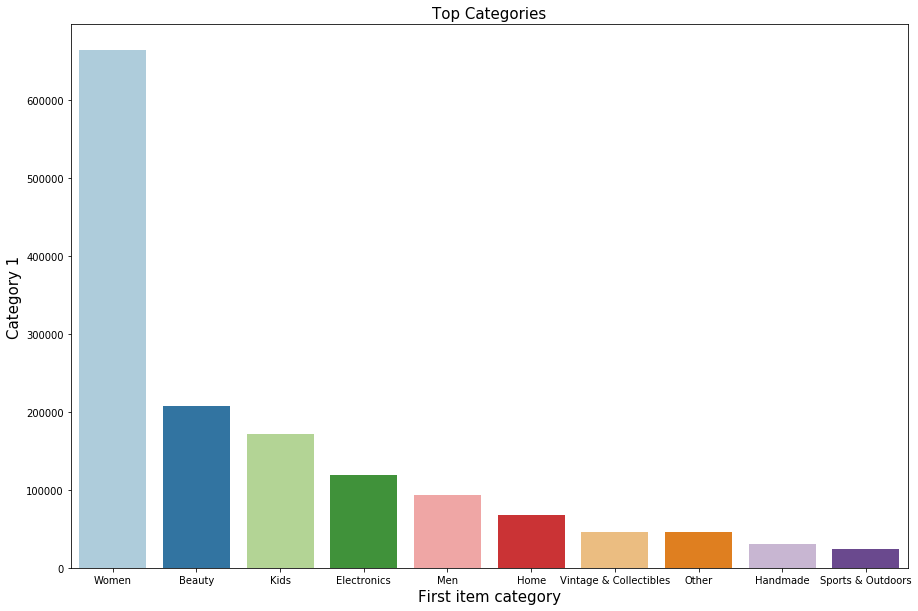

In [219]:
# print 

plt.figure(figsize=(15, 10))
x = data_set['category_1']
y = data_set['category_1'].value_counts().index

sns.countplot(x, order=y, palette='Paired')

plt.title('Top Categories', fontsize=15)
plt.xlabel('First item category', fontsize=15)
plt.ylabel('Category 1', fontsize=15)

plt.show()